# Clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
import sklearn as sk
from sklearn.metrics import accuracy_score
import matplotlib as mpl
mpl.style.use('seaborn')
base = ''

In [2]:
from google.colab import drive
drive.mount('/content/drive')
base = '/content/drive/MyDrive/afarin/MachineLearning/Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = np.load(base + 'mfccaudio_chroma_features_12_all_20Sec_cleaned.pkl', allow_pickle=True)
labels = np.array(np.load(base + 'mfccaudio_chroma_features_12_all_20Sec_labels_cleaned.pkl', allow_pickle=True))

In [ ]:
X = np.array(data)
y = np.array(labels)
X.shape

(9538, 862, 12)

In [ ]:
print('dataset size:', y.shape[0])
print('each record of X:', X[0].shape)

dataset size: 9538
each record of X: (862, 12)


## Chroma Features


### 12 features, all

In [ ]:
# concatanate X dimensions
X12 = X.reshape(X.shape[0], -1)
X12.shape

(9538, 10344)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X12, y, test_size=0.25, random_state=42)

In [18]:
from sklearn.cluster import MiniBatchKMeans

def get_kmeans(X, k):
    kmeans = sk.cluster.KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    return kmeans

In [4]:
from sklearn.cluster import AgglomerativeClustering

def get_agglomerative(X, k, linkage='ward'):
    agg = sk.cluster.AgglomerativeClustering(n_clusters=k, linkage=linkage)
    agg.fit(X)
    return agg

In [5]:
from scipy.stats import mode
import warnings

def label_clusters(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in range(20):
        mask = (y_pred == i)
        # suppress scipy warning
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            labels[mask] = mode(y_true[mask])[0]

    return labels

In [6]:
results = pd.DataFrame(columns=[
    'method', 'k', 'dimensionality', 
    'Adjusted Rand Index', 'Normalized Mutual Info Score', 'Homogeneity Score', 'Completeness Score',
    'train accuracy', 'test accuracy'
])
results = pd.read_csv(base + 'results.csv')

In [7]:
from sklearn.metrics import rand_score, adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score

def evaluate(y_true, y_pred):
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    hom = homogeneity_score(y_true, y_pred)
    com = completeness_score(y_true, y_pred)

    print("\tAdjusted Rand Score:\t{0:.4f}".format(ari))
    print("\tNormalized Mutual Info Score:\t{0:.4f}".format(nmi))
    print("\tHomogeneity Score:\t{0:.4f}".format(hom))
    print("\tCompleteness Score:\t{0:.4f}".format(com))
    
    return [ari, nmi, hom, com]

In [ ]:
k = [2, 7, 20]
for i in k:
    kmeans = get_kmeans(X_train, i)
    print('---- KMeans, k={}, d={} ----'.format(i, X12.shape[1:]))
    y_pred = label_clusters(y_train, kmeans.labels_)
    train_acc = accuracy_score(y_train, y_pred)
    print('train set: (accuracy={:.4f})'.format(train_acc))
    evaluate(y_train, kmeans.labels_)

    predict = kmeans.predict(X_test)
    y_pred = label_clusters(y_test, predict)
    test_acc = accuracy_score(y_test, y_pred)
    print('test set: (accuracy={:.4f})'.format(test_acc))

    res = evaluate(y_test, predict)
    row = ['KMeans', i, X12.shape[1:]] + res + [train_acc, test_acc]
    results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
    print('\n')

In [ ]:
k = [2, 7, 20]
for i in k:
    agg = get_agglomerative(X_train, i)
    print('---- Agglomerative, k={}, d={} ----'.format(i, X12.shape[1:]))
    y_pred = label_clusters(y_train, agg.labels_)
    train_acc = accuracy_score(y_train, y_pred)
    print('train set: (accuracy={:.4f})'.format(train_acc))
    evaluate(y_train, agg.labels_)

    predict = agg.fit_predict(X_test)
    y_pred = label_clusters(y_test, predict)
    test_acc = accuracy_score(y_test, y_pred)
    print('test set: (accuracy={:.4f})'.format(test_acc))
    res = evaluate(y_test, predict)
    row = ['Agglomerative', i, X12.shape[1:]] + res + [train_acc, test_acc]
    results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
    print('\n')

---- Agglomerative, k=2, d=(10344,) ----
train set: (accuracy=0.1836)
	Adjusted Rand Score:	0.0051
	Normalized Mutual Info Score:	0.0093
	Homogeneity Score:	0.0061
	Completeness Score:	0.0192
test set: (accuracy=0.1820)
	Adjusted Rand Score:	0.0021
	Normalized Mutual Info Score:	0.0050
	Homogeneity Score:	0.0032
	Completeness Score:	0.0119


---- Agglomerative, k=7, d=(10344,) ----
train set: (accuracy=0.2132)
	Adjusted Rand Score:	0.0112
	Normalized Mutual Info Score:	0.0194
	Homogeneity Score:	0.0190
	Completeness Score:	0.0199
test set: (accuracy=0.2143)
	Adjusted Rand Score:	0.0091
	Normalized Mutual Info Score:	0.0208
	Homogeneity Score:	0.0203
	Completeness Score:	0.0213


---- Agglomerative, k=20, d=(10344,) ----
train set: (accuracy=0.2533)
	Adjusted Rand Score:	0.0138
	Normalized Mutual Info Score:	0.0364
	Homogeneity Score:	0.0451
	Completeness Score:	0.0305
test set: (accuracy=0.2474)
	Adjusted Rand Score:	0.0110
	Normalized Mutual Info Score:	0.0366
	Homogeneity Score:	0.04

In [ ]:
results.to_csv('results.csv', index=False)

In [ ]:
results[results['dimensionality'] == '(10344,)']

,method,k,dimensionality,Adjusted Rand Index,Normalized Mutual Info Score,Homogeneity Score,Completeness Score,train accuracy,test accuracy
0,KMeans,2,"(10344,)",0.000219,0.001318,0.000894,0.002506,0.170698,0.162264
1,KMeans,7,"(10344,)",0.007590,0.015953,0.015901,0.016006,0.209003,0.210901
2,KMeans,20,"(10344,)",0.013448,0.040760,0.051519,0.033718,0.269118,0.259958
3,Agglomerative,2,"(10344,)",0.002120,0.005009,0.003173,0.011893,0.183559,0.181971
4,Agglomerative,7,"(10344,)",0.009066,0.020815,0.020325,0.021330,0.213197,0.214256
5,Agglomerative,20,"(10344,)",0.011010,0.036569,0.045924,0.030380,0.253320,0.247379


### 12 features, mean

In [ ]:
X_mean = X.mean(axis=1)
X_mean.shape

(9538, 12)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.25, random_state=42)

In [ ]:
k = [2, 7, 20]
for i in k:
    kmeans = get_kmeans(X_train, i)
    print('---- KMeans, k={}, D=12 ----'.format(i))
    predict = kmeans.predict(X_train)
    y_pred = label_clusters(y_train, predict)
    train_acc = accuracy_score(y_train, y_pred)
    print('train set: (accuracy={:.4f})'.format(train_acc))
    evaluate(y_train, kmeans.labels_)
    
    predict = kmeans.predict(X_test)
    y_pred = label_clusters(y_test, predict)
    test_acc = accuracy_score(y_test, y_pred)
    print('test set: (accuracy={:.4f})'.format(test_acc))
    res = evaluate(y_test, predict)

    row = ['KMeans', i, 12] + res + [train_acc, test_acc]
    results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
    print('\n')

---- KMeans, k=2, D=12 ----
train set: (accuracy=0.1717)
	Adjusted Rand Score:	0.0027
	Normalized Mutual Info Score:	0.0039
	Homogeneity Score:	0.0026
	Completeness Score:	0.0074
test set: (accuracy=0.1639)
	Adjusted Rand Score:	0.0003
	Normalized Mutual Info Score:	0.0015
	Homogeneity Score:	0.0010
	Completeness Score:	0.0028


---- KMeans, k=7, D=12 ----
train set: (accuracy=0.2093)
	Adjusted Rand Score:	0.0105
	Normalized Mutual Info Score:	0.0179
	Homogeneity Score:	0.0178
	Completeness Score:	0.0179
test set: (accuracy=0.2109)
	Adjusted Rand Score:	0.0077
	Normalized Mutual Info Score:	0.0158
	Homogeneity Score:	0.0158
	Completeness Score:	0.0159


---- KMeans, k=20, D=12 ----
train set: (accuracy=0.2728)
	Adjusted Rand Score:	0.0190
	Normalized Mutual Info Score:	0.0468
	Homogeneity Score:	0.0594
	Completeness Score:	0.0387
test set: (accuracy=0.2730)
	Adjusted Rand Score:	0.0163
	Normalized Mutual Info Score:	0.0470
	Homogeneity Score:	0.0595
	Completeness Score:	0.0388




In [ ]:
k = [2, 7, 20]
for i in k:
    agg = get_agglomerative(X_train, i)
    print('---- Agglomerative Clustering, k={}, D=12 ----'.format(i))
    predict = agg.fit_predict(X_train)
    y_pred = label_clusters(y_train, predict)
    train_acc = accuracy_score(y_train, y_pred)
    print('train set: (accuracy={:.4f})'.format(train_acc))
    evaluate(y_train, agg.labels_)
    
    predict = agg.fit_predict(X_test)
    y_pred = label_clusters(y_test, predict)
    test_acc = accuracy_score(y_test, y_pred)
    print('test set: (accuracy={:.4f})'.format(test_acc))
    res = evaluate(y_test, predict)
    
    row = ['Agglomerative', i, 12] + res + [train_acc, test_acc]
    results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
    print('\n')

---- Agglomerative Clustering, k=2, D=12 ----
train set: (accuracy=0.1777)
	Adjusted Rand Score:	0.0031
	Normalized Mutual Info Score:	0.0042
	Homogeneity Score:	0.0029
	Completeness Score:	0.0080
test set: (accuracy=0.1719)
	Adjusted Rand Score:	0.0012
	Normalized Mutual Info Score:	0.0024
	Homogeneity Score:	0.0015
	Completeness Score:	0.0058


---- Agglomerative Clustering, k=7, D=12 ----
train set: (accuracy=0.2045)
	Adjusted Rand Score:	0.0078
	Normalized Mutual Info Score:	0.0179
	Homogeneity Score:	0.0175
	Completeness Score:	0.0183
test set: (accuracy=0.2080)
	Adjusted Rand Score:	0.0081
	Normalized Mutual Info Score:	0.0206
	Homogeneity Score:	0.0202
	Completeness Score:	0.0209


---- Agglomerative Clustering, k=20, D=12 ----
train set: (accuracy=0.2673)
	Adjusted Rand Score:	0.0176
	Normalized Mutual Info Score:	0.0466
	Homogeneity Score:	0.0582
	Completeness Score:	0.0389
test set: (accuracy=0.2537)
	Adjusted Rand Score:	0.0136
	Normalized Mutual Info Score:	0.0424
	Homogene

In [ ]:
results[results['dimensionality'] == 12]

,method,k,dimensionality,Adjusted Rand Index,Normalized Mutual Info Score,Homogeneity Score,Completeness Score,train accuracy,test accuracy
12,KMeans,2,12,0.000319,0.001453,0.000986,0.002761,0.171676,0.163941
13,KMeans,7,12,0.007730,0.015830,0.015771,0.015890,0.209283,0.210901
14,KMeans,20,12,0.016253,0.046975,0.059517,0.038799,0.272753,0.272956
15,Agglomerative,2,12,0.001196,0.002415,0.001525,0.005808,0.177688,0.171908
16,Agglomerative,7,12,0.008124,0.020563,0.020231,0.020907,0.204530,0.207966
17,Agglomerative,20,12,0.013550,0.042440,0.052979,0.035398,0.267300,0.253669


In [ ]:
results.to_csv(base+'results.csv', index=False)

### 36 features, all

In [9]:
data = np.load(base + 'mfccaudio_chroma_features_36_all_20Sec_cleaned.pkl', allow_pickle=True)
labels = np.array(np.load(base + 'mfccaudio_chroma_features_36_all_20Sec_labels_cleaned.pkl', allow_pickle=True))

In [10]:
X36 = np.array(data)
y = np.array(labels)
X36.shape

(9538, 862, 36)

In [11]:
# concatanate X dimensions
X36_all = X36.reshape(X36.shape[0], -1)
X36_all.shape

(9538, 31032)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X36_all, y, test_size=0.25, random_state=42)

In [ ]:
k = [2, 7, 20]
for i in k:
    kmeans = get_kmeans(X_train, i)
    print('---- KMeans, k={}, D={} ----'.format(i, X36_all.shape[1]))
    predict = kmeans.predict(X_train)
    y_pred = label_clusters(y_train, predict)
    train_acc = accuracy_score(y_train, y_pred)
    print('train set: (accuracy={:.4f})'.format(train_acc))
    evaluate(y_train, kmeans.labels_)
    
    predict = kmeans.predict(X_test)
    y_pred = label_clusters(y_test, predict)
    test_acc = accuracy_score(y_test, y_pred)
    print('test set: (accuracy={:.4f})'.format(test_acc))
    res = evaluate(y_test, predict)

    row = ['KMeans', i, X36_all.shape[1]] + res + [train_acc, test_acc]
    results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
    print('\n')

---- KMeans, k=2, D=31032 ----
train set: (accuracy=0.1706)
	Adjusted Rand Score:	0.0019
	Normalized Mutual Info Score:	0.0033
	Homogeneity Score:	0.0022
	Completeness Score:	0.0065
test set: (accuracy=0.1648)
	Adjusted Rand Score:	0.0008
	Normalized Mutual Info Score:	0.0026
	Homogeneity Score:	0.0017
	Completeness Score:	0.0051


---- KMeans, k=7, D=31032 ----
train set: (accuracy=0.2108)
	Adjusted Rand Score:	0.0096
	Normalized Mutual Info Score:	0.0163
	Homogeneity Score:	0.0162
	Completeness Score:	0.0163
test set: (accuracy=0.2134)
	Adjusted Rand Score:	0.0104
	Normalized Mutual Info Score:	0.0208
	Homogeneity Score:	0.0208
	Completeness Score:	0.0209


---- KMeans, k=20, D=31032 ----
train set: (accuracy=0.2591)
	Adjusted Rand Score:	0.0166
	Normalized Mutual Info Score:	0.0421
	Homogeneity Score:	0.0532
	Completeness Score:	0.0348
test set: (accuracy=0.2507)
	Adjusted Rand Score:	0.0133
	Normalized Mutual Info Score:	0.0446
	Homogeneity Score:	0.0562
	Completeness Score:	0.0369

In [ ]:
results[results['dimensionality'] == 31032]

,method,k,dimensionality,Adjusted Rand Index,Normalized Mutual Info Score,Homogeneity Score,Completeness Score,train accuracy,test accuracy
12,KMeans,2,31032,0.000849,0.002591,0.001732,0.005138,0.170558,0.164780
13,KMeans,7,31032,0.010447,0.020821,0.020755,0.020887,0.210821,0.213417
14,KMeans,20,31032,0.013322,0.044562,0.056235,0.036903,0.259052,0.250734


### 36 features, mean

In [20]:
X_mean = X36.mean(axis=1)
X_mean.shape

(9538, 36)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.25, random_state=42)

In [ ]:
k = [2, 7, 20]
for i in k:
    kmeans = get_kmeans(X_train, i)
    print('---- KMeans, k={}, D={} ----'.format(i, X_mean.shape[1]))
    predict = kmeans.predict(X_train)
    y_pred = label_clusters(y_train, predict)
    train_acc = accuracy_score(y_train, y_pred)
    print('train set: (accuracy={:.4f})'.format(train_acc))
    evaluate(y_train, kmeans.labels_)
    
    predict = kmeans.predict(X_test)
    y_pred = label_clusters(y_test, predict)
    test_acc = accuracy_score(y_test, y_pred)
    print('test set: (accuracy={:.4f})'.format(test_acc))
    res = evaluate(y_test, predict)

    row = ['KMeans', i, X_mean.shape[1]] + res + [train_acc, test_acc]
    results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
    print('\n')

---- KMeans, k=2, D=36 ----
train set: (accuracy=0.1701)
	Adjusted Rand Score:	0.0019
	Normalized Mutual Info Score:	0.0033
	Homogeneity Score:	0.0022
	Completeness Score:	0.0066
test set: (accuracy=0.1652)
	Adjusted Rand Score:	0.0007
	Normalized Mutual Info Score:	0.0024
	Homogeneity Score:	0.0016
	Completeness Score:	0.0048


---- KMeans, k=7, D=36 ----
train set: (accuracy=0.2076)
	Adjusted Rand Score:	0.0103
	Normalized Mutual Info Score:	0.0184
	Homogeneity Score:	0.0183
	Completeness Score:	0.0184
test set: (accuracy=0.2151)
	Adjusted Rand Score:	0.0121
	Normalized Mutual Info Score:	0.0234
	Homogeneity Score:	0.0233
	Completeness Score:	0.0234


---- KMeans, k=20, D=36 ----
train set: (accuracy=0.2627)
	Adjusted Rand Score:	0.0185
	Normalized Mutual Info Score:	0.0463
	Homogeneity Score:	0.0585
	Completeness Score:	0.0384
test set: (accuracy=0.2537)
	Adjusted Rand Score:	0.0144
	Normalized Mutual Info Score:	0.0456
	Homogeneity Score:	0.0576
	Completeness Score:	0.0377




In [ ]:
k = [2, 7, 20]
for i in k:
    agg = get_agglomerative(X_train, i)
    print('---- Agglomerative Clustering, k={}, D={} ----'.format(i, X_mean.shape[1]))
    predict = agg.fit_predict(X_train)
    y_pred = label_clusters(y_train, predict)
    train_acc = accuracy_score(y_train, y_pred)
    print('train set: (accuracy={:.4f})'.format(train_acc))
    evaluate(y_train, agg.labels_)
    
    predict = agg.fit_predict(X_test)
    y_pred = label_clusters(y_test, predict)
    test_acc = accuracy_score(y_test, y_pred)
    print('test set: (accuracy={:.4f})'.format(test_acc))
    res = evaluate(y_test, predict)
    
    row = ['Agglomerative', i, X_mean.shape[1]] + res + [train_acc, test_acc]
    results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
    print('\n')

---- Agglomerative Clustering, k=2, D=36 ----
train set: (accuracy=0.1597)
	Adjusted Rand Score:	0.0003
	Normalized Mutual Info Score:	0.0024
	Homogeneity Score:	0.0014
	Completeness Score:	0.0097
test set: (accuracy=0.1941)
	Adjusted Rand Score:	0.0077
	Normalized Mutual Info Score:	0.0140
	Homogeneity Score:	0.0091
	Completeness Score:	0.0297


---- Agglomerative Clustering, k=7, D=36 ----
train set: (accuracy=0.2114)
	Adjusted Rand Score:	0.0116
	Normalized Mutual Info Score:	0.0227
	Homogeneity Score:	0.0220
	Completeness Score:	0.0235
test set: (accuracy=0.2382)
	Adjusted Rand Score:	0.0169
	Normalized Mutual Info Score:	0.0290
	Homogeneity Score:	0.0283
	Completeness Score:	0.0298


---- Agglomerative Clustering, k=20, D=36 ----
train set: (accuracy=0.2739)
	Adjusted Rand Score:	0.0221
	Normalized Mutual Info Score:	0.0624
	Homogeneity Score:	0.0778
	Completeness Score:	0.0521
test set: (accuracy=0.2876)
	Adjusted Rand Score:	0.0212
	Normalized Mutual Info Score:	0.0779
	Homogene

In [ ]:
results[results['dimensionality'] == 36]

,method,k,dimensionality,Adjusted Rand Index,Normalized Mutual Info Score,Homogeneity Score,Completeness Score,train accuracy,test accuracy
15,KMeans,2,36,0.000723,0.002446,0.001636,0.004846,0.170138,0.165199
16,KMeans,7,36,0.012137,0.023355,0.023292,0.023420,0.207605,0.215094
17,KMeans,20,36,0.014373,0.045562,0.057553,0.037707,0.262687,0.253669
18,Agglomerative,2,36,0.007692,0.013954,0.009117,0.029725,0.159653,0.194130
19,Agglomerative,7,36,0.016911,0.029050,0.028317,0.029822,0.211380,0.238155
20,Agglomerative,20,36,0.021248,0.077932,0.095220,0.065957,0.273871,0.287631


### 24 features, all

In [26]:
data = np.load(base + 'mfccaudio_chroma_features_24_all_20Sec_cleaned.pkl', allow_pickle=True)
labels = np.array(np.load(base + 'mfccaudio_chroma_features_24_all_20Sec_labels_cleaned.pkl', allow_pickle=True))

In [27]:
X24 = np.array(data)
X24.shape

(9538, 862, 24)

In [ ]:
# concatanate X dimensions
X24_all = X24.reshape(X24.shape[0], -1)
X24_all.shape

(9538, 20688)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X24_all, y, test_size=0.25, random_state=42)

In [ ]:
k = [2, 7, 20]
for i in k:
    kmeans = get_kmeans(X_train, i)
    print('---- KMeans, k={}, D={} ----'.format(i, X24_all.shape[1]))
    predict = kmeans.predict(X_train)
    y_pred = label_clusters(y_train, predict)
    train_acc = accuracy_score(y_train, y_pred)
    print('train set: (accuracy={:.4f})'.format(train_acc))
    evaluate(y_train, kmeans.labels_)
    
    predict = kmeans.predict(X_test)
    y_pred = label_clusters(y_test, predict)
    test_acc = accuracy_score(y_test, y_pred)
    print('test set: (accuracy={:.4f})'.format(test_acc))
    res = evaluate(y_test, predict)

    row = ['KMeans', i, X24_all.shape[1]] + res + [train_acc, test_acc]
    results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
    print('\n')

---- KMeans, k=2, D=20688 ----
train set: (accuracy=0.1710)
	Adjusted Rand Score:	0.0022
	Normalized Mutual Info Score:	0.0033
	Homogeneity Score:	0.0022
	Completeness Score:	0.0063
test set: (accuracy=0.1631)
	Adjusted Rand Score:	0.0004
	Normalized Mutual Info Score:	0.0019
	Homogeneity Score:	0.0013
	Completeness Score:	0.0037


---- KMeans, k=7, D=20688 ----
train set: (accuracy=0.2273)
	Adjusted Rand Score:	0.0142
	Normalized Mutual Info Score:	0.0246
	Homogeneity Score:	0.0245
	Completeness Score:	0.0247
test set: (accuracy=0.2273)
	Adjusted Rand Score:	0.0127
	Normalized Mutual Info Score:	0.0255
	Homogeneity Score:	0.0253
	Completeness Score:	0.0256


---- KMeans, k=20, D=20688 ----
train set: (accuracy=0.2638)
	Adjusted Rand Score:	0.0188
	Normalized Mutual Info Score:	0.0456
	Homogeneity Score:	0.0576
	Completeness Score:	0.0378
test set: (accuracy=0.2629)
	Adjusted Rand Score:	0.0185
	Normalized Mutual Info Score:	0.0524
	Homogeneity Score:	0.0661
	Completeness Score:	0.0434

In [ ]:
results[results['dimensionality'] == 20688]

,method,k,dimensionality,Adjusted Rand Index,Normalized Mutual Info Score,Homogeneity Score,Completeness Score,train accuracy,test accuracy
21,KMeans,2,20688,0.000422,0.001915,0.001291,0.003708,0.170977,0.163103
22,KMeans,7,20688,0.012698,0.025455,0.025286,0.025626,0.227317,0.227254
23,KMeans,20,20688,0.018482,0.052428,0.066088,0.043447,0.263805,0.262893


### 24 features, mean

In [28]:
X_mean = X24.mean(axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.25, random_state=42)

In [ ]:
k = [2, 7, 20]
for i in k:
    kmeans = get_kmeans(X_train, i)
    print('---- KMeans, k={}, D={} ----'.format(i, X_mean.shape[1]))
    predict = kmeans.predict(X_train)
    y_pred = label_clusters(y_train, predict)
    train_acc = accuracy_score(y_train, y_pred)
    print('train set: (accuracy={:.4f})'.format(train_acc))
    evaluate(y_train, kmeans.labels_)
    
    predict = kmeans.predict(X_test)
    y_pred = label_clusters(y_test, predict)
    test_acc = accuracy_score(y_test, y_pred)
    print('test set: (accuracy={:.4f})'.format(test_acc))
    res = evaluate(y_test, predict)

    row = ['KMeans', i, X_mean.shape[1]] + res + [train_acc, test_acc]
    results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
    print('\n')

---- KMeans, k=2, D=24 ----
train set: (accuracy=0.1728)
	Adjusted Rand Score:	0.0024
	Normalized Mutual Info Score:	0.0034
	Homogeneity Score:	0.0023
	Completeness Score:	0.0066
test set: (accuracy=0.1635)
	Adjusted Rand Score:	0.0004
	Normalized Mutual Info Score:	0.0017
	Homogeneity Score:	0.0012
	Completeness Score:	0.0034


---- KMeans, k=7, D=24 ----
train set: (accuracy=0.2297)
	Adjusted Rand Score:	0.0158
	Normalized Mutual Info Score:	0.0269
	Homogeneity Score:	0.0268
	Completeness Score:	0.0270
test set: (accuracy=0.2314)
	Adjusted Rand Score:	0.0143
	Normalized Mutual Info Score:	0.0271
	Homogeneity Score:	0.0270
	Completeness Score:	0.0273


---- KMeans, k=20, D=24 ----
train set: (accuracy=0.2655)
	Adjusted Rand Score:	0.0192
	Normalized Mutual Info Score:	0.0477
	Homogeneity Score:	0.0601
	Completeness Score:	0.0395
test set: (accuracy=0.2625)
	Adjusted Rand Score:	0.0171
	Normalized Mutual Info Score:	0.0536
	Homogeneity Score:	0.0675
	Completeness Score:	0.0445




In [ ]:
k = [2, 7, 20]
for i in k:
    agg = get_agglomerative(X_train, i)
    print('---- Agglomerative Clustering, k={}, D={} ----'.format(i, X_mean.shape[1]))
    predict = agg.fit_predict(X_train)
    y_pred = label_clusters(y_train, predict)
    train_acc = accuracy_score(y_train, y_pred)
    print('train set: (accuracy={:.4f})'.format(train_acc))
    evaluate(y_train, agg.labels_)
    
    predict = agg.fit_predict(X_test)
    y_pred = label_clusters(y_test, predict)
    test_acc = accuracy_score(y_test, y_pred)
    print('test set: (accuracy={:.4f})'.format(test_acc))
    res = evaluate(y_test, predict)
    
    row = ['Agglomerative', i, X_mean.shape[1]] + res + [train_acc, test_acc]
    results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
    print('\n')

---- Agglomerative Clustering, k=2, D=24 ----
train set: (accuracy=0.1711)
	Adjusted Rand Score:	0.0030
	Normalized Mutual Info Score:	0.0040
	Homogeneity Score:	0.0027
	Completeness Score:	0.0077
test set: (accuracy=0.1740)
	Adjusted Rand Score:	0.0047
	Normalized Mutual Info Score:	0.0112
	Homogeneity Score:	0.0075
	Completeness Score:	0.0223


---- Agglomerative Clustering, k=7, D=24 ----
train set: (accuracy=0.1975)
	Adjusted Rand Score:	0.0110
	Normalized Mutual Info Score:	0.0208
	Homogeneity Score:	0.0207
	Completeness Score:	0.0209
test set: (accuracy=0.2260)
	Adjusted Rand Score:	0.0163
	Normalized Mutual Info Score:	0.0337
	Homogeneity Score:	0.0334
	Completeness Score:	0.0341


---- Agglomerative Clustering, k=20, D=24 ----
train set: (accuracy=0.2648)
	Adjusted Rand Score:	0.0201
	Normalized Mutual Info Score:	0.0526
	Homogeneity Score:	0.0659
	Completeness Score:	0.0438
test set: (accuracy=0.2788)
	Adjusted Rand Score:	0.0210
	Normalized Mutual Info Score:	0.0614
	Homogene

In [ ]:
results[results['dimensionality'] == 24]

,method,k,dimensionality,Adjusted Rand Index,Normalized Mutual Info Score,Homogeneity Score,Completeness Score,train accuracy,test accuracy
24,KMeans,2,24,0.000389,0.001734,0.001170,0.003355,0.172795,0.163522
25,KMeans,7,24,0.014306,0.027111,0.026956,0.027268,0.229694,0.231447
26,KMeans,20,24,0.017115,0.053619,0.067496,0.044476,0.265483,0.262474
27,Agglomerative,2,24,0.004718,0.011179,0.007456,0.022334,0.171117,0.174004
28,Agglomerative,7,24,0.016305,0.033744,0.033410,0.034084,0.197539,0.225996
29,Agglomerative,20,24,0.020993,0.061447,0.077265,0.051005,0.264784,0.278826


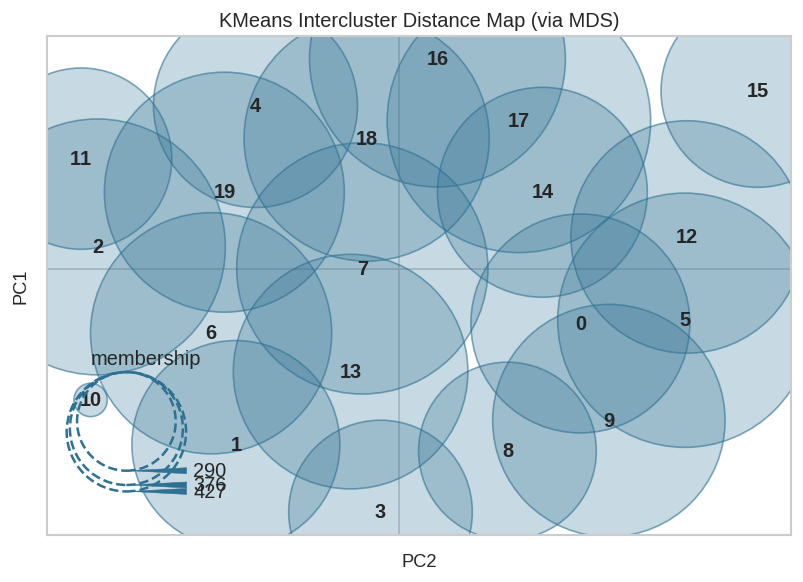

InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bc8af04f0>,
                     estimator=KMeans(n_clusters=20, random_state=42))

In [32]:
from yellowbrick.cluster import intercluster_distance

kmeans = get_kmeans(X_train, 20)
intercluster_distance(kmeans, X_train)

## MFCC Features

In [ ]:
data = np.load(base + 'mfccaudio_mfcc_features_40_all_20Sec_cleaned.pkl', allow_pickle=True)
labels = np.array(np.load(base + 'mfccaudio_mfcc_features_40_all_20Sec_labels_cleaned.pkl', allow_pickle=True))

In [ ]:
X_mfcc = np.array(data)
y = np.array(labels)
y = np.array([y[i] for i in range(len(y)) if np.array(X_mfcc[i]).shape == (862, 40)])
X_mfcc = np.array([x for x in X_mfcc if np.array(x).shape == (862, 40)])
X_mfcc.shape

<ipython-input-28-5f7646f740fa>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_mfcc = np.array(data)


(9523, 862, 40)

### 40 features (mfcc), all

In [ ]:
X40_all = X_mfcc.reshape(X_mfcc.shape[0], -1)
X40_all.shape

(9523, 34480)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X40, y, test_size=0.25, random_state=42)

In [ ]:
k = [2, 7, 20]
for i in k:
    kmeans = get_kmeans(X_train, i)
    print('---- KMeans, k={}, D={} ----'.format(i, X40_all.shape[1]))
    predict = kmeans.predict(X_train)
    y_pred = label_clusters(y_train, predict)
    train_acc = accuracy_score(y_train, y_pred)
    print('train set: (accuracy={:.4f})'.format(train_acc))
    evaluate(y_train, kmeans.labels_)
    
    predict = kmeans.predict(X_test)
    y_pred = label_clusters(y_test, predict)
    test_acc = accuracy_score(y_test, y_pred)
    print('test set: (accuracy={:.4f})'.format(test_acc))
    res = evaluate(y_test, predict)

    row = ['KMeans', i, X40_all.shape[1]] + res + [train_acc, test_acc]
    results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
    print('\n')

---- KMeans, k=2, D=34480 ----
train set: (accuracy=0.1694)
	Adjusted Rand Score:	0.0037
	Normalized Mutual Info Score:	0.0057
	Homogeneity Score:	0.0038
	Completeness Score:	0.0108
test set: (accuracy=0.1672)
	Adjusted Rand Score:	0.0041
	Normalized Mutual Info Score:	0.0070
	Homogeneity Score:	0.0047
	Completeness Score:	0.0133


---- KMeans, k=7, D=34480 ----
train set: (accuracy=0.1879)
	Adjusted Rand Score:	0.0054
	Normalized Mutual Info Score:	0.0108
	Homogeneity Score:	0.0107
	Completeness Score:	0.0110
test set: (accuracy=0.1907)
	Adjusted Rand Score:	0.0057
	Normalized Mutual Info Score:	0.0131
	Homogeneity Score:	0.0130
	Completeness Score:	0.0133


---- KMeans, k=20, D=34480 ----
train set: (accuracy=0.2092)
	Adjusted Rand Score:	0.0095
	Normalized Mutual Info Score:	0.0238
	Homogeneity Score:	0.0294
	Completeness Score:	0.0200
test set: (accuracy=0.2264)
	Adjusted Rand Score:	0.0073
	Normalized Mutual Info Score:	0.0262
	Homogeneity Score:	0.0325
	Completeness Score:	0.0220

In [ ]:
results[results['dimensionality'] == X40_all.shape[1]]

,method,k,dimensionality,Adjusted Rand Index,Normalized Mutual Info Score,Homogeneity Score,Completeness Score,train accuracy,test accuracy
30,KMeans,2,34480,0.004085,0.006974,0.004732,0.013251,0.169420,0.167157
31,KMeans,7,34480,0.005682,0.013135,0.013011,0.013262,0.187903,0.190676
32,KMeans,20,34480,0.007320,0.026234,0.032494,0.021996,0.209185,0.226375


### 40 features (mfcc), mean

In [ ]:
X_mean = X_mfcc.mean(axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.25, random_state=42)

In [ ]:
k = [2, 7, 20]
for i in k:
    kmeans = get_kmeans(X_train, i)
    print('---- KMeans, k={}, D={} ----'.format(i, X_mean.shape[1]))
    predict = kmeans.predict(X_train)
    y_pred = label_clusters(y_train, predict)
    train_acc = accuracy_score(y_train, y_pred)
    print('train set: (accuracy={:.4f})'.format(train_acc))
    evaluate(y_train, kmeans.labels_)
    
    predict = kmeans.predict(X_test)
    y_pred = label_clusters(y_test, predict)
    test_acc = accuracy_score(y_test, y_pred)
    print('test set: (accuracy={:.4f})'.format(test_acc))
    res = evaluate(y_test, predict)

    row = ['KMeans', i, X_mean.shape[1]] + res + [train_acc, test_acc]
    results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
    print('\n')

---- KMeans, k=2, D=40 ----
train set: (accuracy=0.1693)
	Adjusted Rand Score:	0.0036
	Normalized Mutual Info Score:	0.0055
	Homogeneity Score:	0.0037
	Completeness Score:	0.0104
test set: (accuracy=0.1667)
	Adjusted Rand Score:	0.0042
	Normalized Mutual Info Score:	0.0072
	Homogeneity Score:	0.0049
	Completeness Score:	0.0138


---- KMeans, k=7, D=40 ----
train set: (accuracy=0.1873)
	Adjusted Rand Score:	0.0054
	Normalized Mutual Info Score:	0.0103
	Homogeneity Score:	0.0102
	Completeness Score:	0.0104
test set: (accuracy=0.1865)
	Adjusted Rand Score:	0.0041
	Normalized Mutual Info Score:	0.0104
	Homogeneity Score:	0.0103
	Completeness Score:	0.0104


---- KMeans, k=20, D=40 ----
train set: (accuracy=0.2251)
	Adjusted Rand Score:	0.0099
	Normalized Mutual Info Score:	0.0292
	Homogeneity Score:	0.0365
	Completeness Score:	0.0243
test set: (accuracy=0.2297)
	Adjusted Rand Score:	0.0084
	Normalized Mutual Info Score:	0.0325
	Homogeneity Score:	0.0407
	Completeness Score:	0.0270




In [ ]:
k = [2, 7, 20]
for i in k:
    agg = get_agglomerative(X_train, i)
    print('---- Agglomerative Clustering, k={}, D={} ----'.format(i, X_mean.shape[1]))
    predict = agg.fit_predict(X_train)
    y_pred = label_clusters(y_train, predict)
    train_acc = accuracy_score(y_train, y_pred)
    print('train set: (accuracy={:.4f})'.format(train_acc))
    evaluate(y_train, agg.labels_)
    
    predict = agg.fit_predict(X_test)
    y_pred = label_clusters(y_test, predict)
    test_acc = accuracy_score(y_test, y_pred)
    print('test set: (accuracy={:.4f})'.format(test_acc))
    res = evaluate(y_test, predict)
    
    row = ['Agglomerative', i, X_mean.shape[1]] + res + [train_acc, test_acc]
    results = pd.concat([results, pd.DataFrame([row], columns=results.columns)], ignore_index=True)
    print('\n')

---- Agglomerative Clustering, k=2, D=40 ----
train set: (accuracy=0.1698)
	Adjusted Rand Score:	0.0034
	Normalized Mutual Info Score:	0.0055
	Homogeneity Score:	0.0037
	Completeness Score:	0.0105
test set: (accuracy=0.1680)
	Adjusted Rand Score:	0.0016
	Normalized Mutual Info Score:	0.0057
	Homogeneity Score:	0.0038
	Completeness Score:	0.0116


---- Agglomerative Clustering, k=7, D=40 ----
train set: (accuracy=0.1924)
	Adjusted Rand Score:	0.0074
	Normalized Mutual Info Score:	0.0148
	Homogeneity Score:	0.0143
	Completeness Score:	0.0154
test set: (accuracy=0.1970)
	Adjusted Rand Score:	0.0064
	Normalized Mutual Info Score:	0.0158
	Homogeneity Score:	0.0153
	Completeness Score:	0.0163


---- Agglomerative Clustering, k=20, D=40 ----
train set: (accuracy=0.2327)
	Adjusted Rand Score:	0.0126
	Normalized Mutual Info Score:	0.0346
	Homogeneity Score:	0.0430
	Completeness Score:	0.0289
test set: (accuracy=0.2335)
	Adjusted Rand Score:	0.0108
	Normalized Mutual Info Score:	0.0404
	Homogene

In [ ]:
results[results['dimensionality'] == 40]

,method,k,dimensionality,Adjusted Rand Index,Normalized Mutual Info Score,Homogeneity Score,Completeness Score,train accuracy,test accuracy
33,KMeans,2,40,0.004218,0.007240,0.004913,0.013757,0.169280,0.166737
34,KMeans,7,40,0.004093,0.010367,0.010313,0.010421,0.187342,0.186476
35,KMeans,20,40,0.008382,0.032470,0.040653,0.027029,0.225147,0.229735
36,Agglomerative,2,40,0.001593,0.005670,0.003756,0.011565,0.169840,0.167997
37,Agglomerative,7,40,0.006434,0.015816,0.015348,0.016314,0.192383,0.196976
38,Agglomerative,20,40,0.010806,0.040400,0.050021,0.033883,0.232708,0.233515


## Performance Comparison

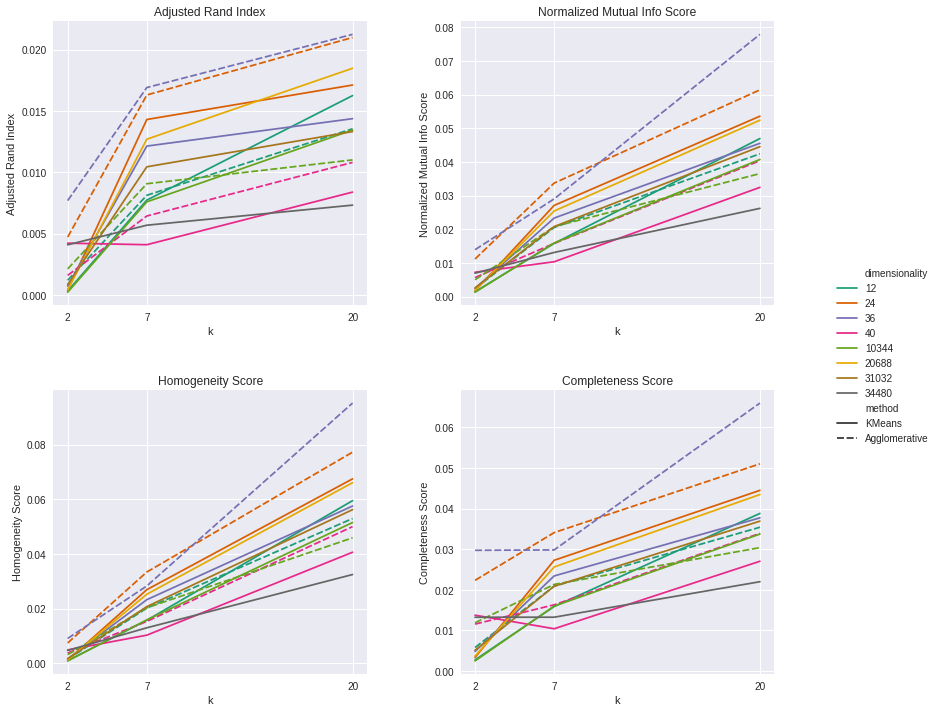

In [39]:
import matplotlib as mpl

mpl.style.use('seaborn')
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

sns.lineplot(x='k', y='Adjusted Rand Index', 
            style='method', hue='dimensionality', 
            data=results, ax=axs[0, 0], palette='Dark2', legend=False)

axs[0, 0].set_title('Adjusted Rand Index')
axs[0,0].set_xticks([2, 7, 20])
axs[0, 0].set_xlabel('k')
axs[0, 0].set_ylabel('Adjusted Rand Index')

sns.lineplot(x='k', y='Normalized Mutual Info Score',
            style='method', hue='dimensionality',
            data=results, ax=axs[0, 1], palette='Dark2', legend=False)

axs[0, 1].set_title('Normalized Mutual Info Score')
axs[0, 1].set_xticks([2, 7, 20])
axs[0, 1].set_xlabel('k')
axs[0, 1].set_ylabel('Normalized Mutual Info Score')

sns.lineplot(x='k', y='Homogeneity Score',
            style='method', hue='dimensionality',
            data=results, ax=axs[1,0], palette='Dark2', legend=False)

axs[1,0].set_title('Homogeneity Score')
axs[1,0].set_xticks([2, 7, 20])
axs[1,0].set_xlabel('k')
axs[1,0].set_ylabel('Homogeneity Score')

sns.lineplot(x='k', y='Completeness Score',
            style='method', hue='dimensionality',
            data=results, ax=axs[1,1], palette='Dark2', legend='full')

axs[1,1].set_title('Completeness Score')
axs[1,1].set_xticks([2, 7, 20])
axs[1,1].set_xlabel('k')
axs[1,1].set_ylabel('Completeness Score')

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.subplots_adjust(right=0.84)
axs[1,1].get_legend().remove()

plt.show()

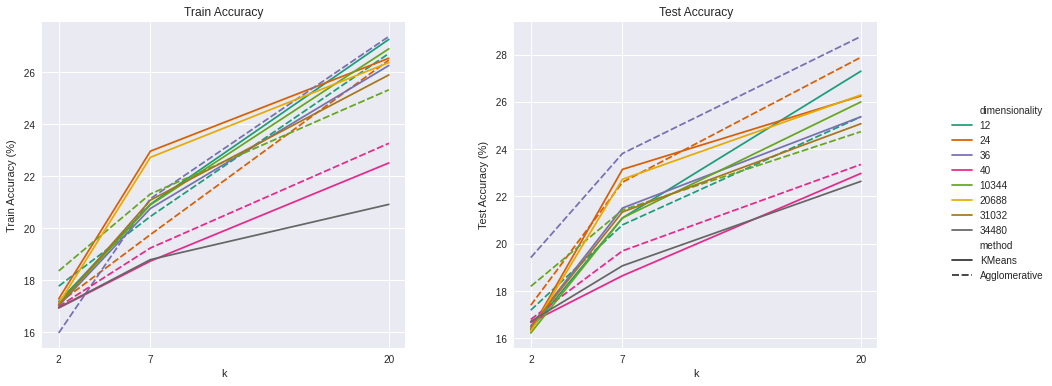

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

sns.lineplot(x='k', y='train accuracy',
            style='method', hue='dimensionality',
            data=results, ax=axs[0], palette='Dark2', legend=False)
axs[0].legend(loc='lower right')
axs[0].set_title('Train Accuracy')
axs[0].set_xticks([2, 7, 20])
axs[0].set_xlabel('k')
axs[0].set_ylabel('Train Accuracy (%)')

vals = axs[0].get_yticks()
axs[0].set_yticklabels(['{:3.0f}'.format(x*100) for x in vals])

sns.lineplot(x='k', y='test accuracy',
            style='method', hue='dimensionality',
            data=results, ax=axs[1], palette='Dark2')
axs[1].legend(loc='lower right')
axs[1].set_title('Test Accuracy')
axs[1].set_xticks([2, 7, 20])
axs[1].set_xlabel('k')
axs[1].set_ylabel('Test Accuracy (%)')

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.subplots_adjust(right=0.85)
axs[1].get_legend().remove()

vals = axs[1].get_yticks()
axs[1].set_yticklabels(['{:3.0f}'.format(x*100) for x in vals])
plt.show()

## Analysis on Best-performing Clustering

In [47]:
X_mean = X36.mean(axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.25, random_state=42, stratify=y)

In [16]:
label_names = [
    'Shoor',
    'Segāh',
    'Mahoor',
    'Homayoun',
    'Rāst Panjgāh',
    'Navā',
    'Chahargāh'
]

In [13]:
mpl.rcParams['figure.dpi'] = 100

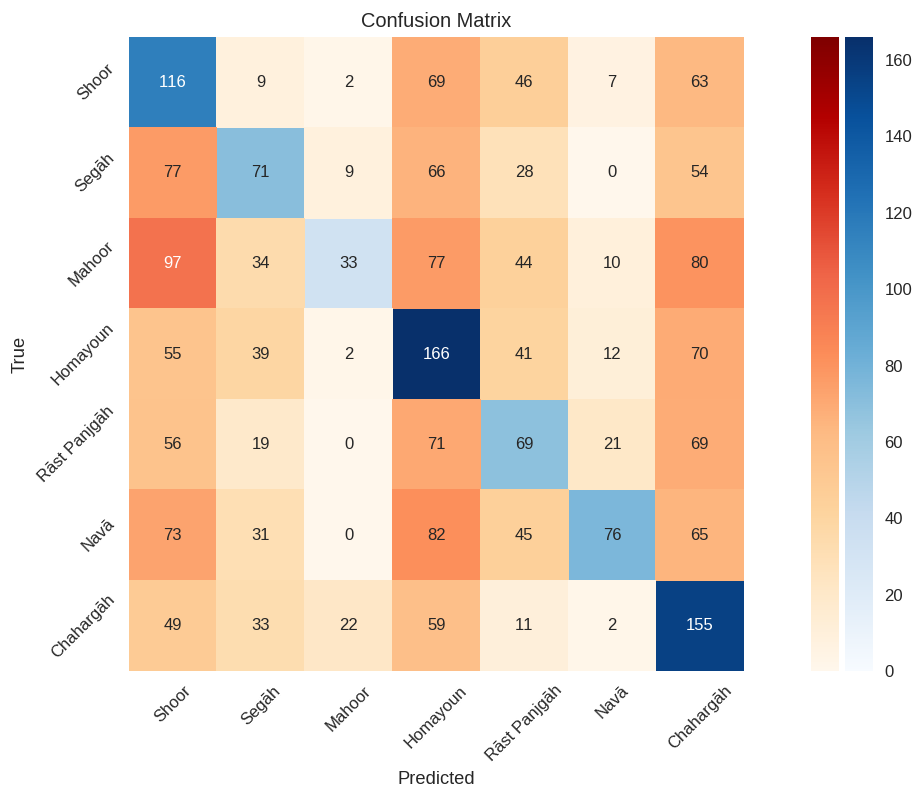

In [15]:
from sklearn.metrics import confusion_matrix

agg = get_agglomerative(X_train, 20)
agg.fit_predict(X_train)
predict = agg.fit_predict(X_test)
y_pred = label_clusters(y_test, predict)
cm = confusion_matrix(y_test, y_pred)

vmin = np.min(cm)
vmax = np.max(cm)
off_diag_mask = np.eye(*cm.shape, dtype=bool)

fig = plt.figure(figsize=(8, 7))
gs0 = mpl.gridspec.GridSpec(1,2, width_ratios=[20,2], hspace=0.05)
gs00 = mpl.gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[1], hspace=0)

ax = fig.add_subplot(gs0[0])
cax1 = fig.add_subplot(gs00[0])
cax2 = fig.add_subplot(gs00[1])

sns.heatmap(cm, annot=True, fmt='g',
            mask=~off_diag_mask, cmap='Blues', 
            vmin=vmin, vmax=vmax, 
            ax=ax, cbar_ax=cax2
            )
sns.heatmap(cm, annot=True, fmt='g',
            mask=off_diag_mask, cmap='OrRd', 
            vmin=vmin, vmax=vmax, 
            ax=ax, cbar_ax=cax1, cbar_kws=dict(ticks=[])
            )

ax.set_xticklabels(label_names, rotation=45)
ax.set_yticklabels(label_names, rotation=45)

ax.set_title('Confusion Matrix', y=1.2)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

In [16]:
from sklearn.metrics import classification_report
predict = agg.fit_predict(X_train)
y_pred = label_clusters(y_train, predict)
print('training')
print(classification_report(y_train, y_pred, target_names=label_names, zero_division=0))

training
              precision    recall  f1-score   support

       Shoor       0.19      0.20      0.20       942
       Segāh       0.23      0.14      0.17       959
      Mahoor       0.22      0.48      0.30      1057
    Homayoun       0.26      0.19      0.22      1091
Rāst Panjgāh       0.30      0.08      0.12       910
        Navā       0.32      0.42      0.37      1142
   Chahargāh       0.48      0.36      0.41      1052

    accuracy                           0.27      7153
   macro avg       0.29      0.27      0.25      7153
weighted avg       0.29      0.27      0.26      7153



In [17]:
predict = agg.fit_predict(X_test)
y_pred = label_clusters(y_test, predict)
print('testing')
print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))

testing
              precision    recall  f1-score   support

       Shoor       0.22      0.37      0.28       312
       Segāh       0.30      0.23      0.26       305
      Mahoor       0.49      0.09      0.15       375
    Homayoun       0.28      0.43      0.34       385
Rāst Panjgāh       0.24      0.23      0.23       305
        Navā       0.59      0.20      0.30       372
   Chahargāh       0.28      0.47      0.35       331

    accuracy                           0.29      2385
   macro avg       0.34      0.29      0.27      2385
weighted avg       0.35      0.29      0.27      2385



*below code is taken from ScikitLearn's documentation for visualising a hierarchical clustering dendogram.*

In [ ]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X_train)

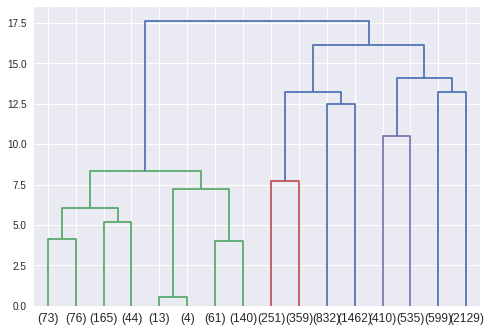

In [ ]:
plot_dendrogram(model, truncate_mode="level", p=3)

#### Linkage Types

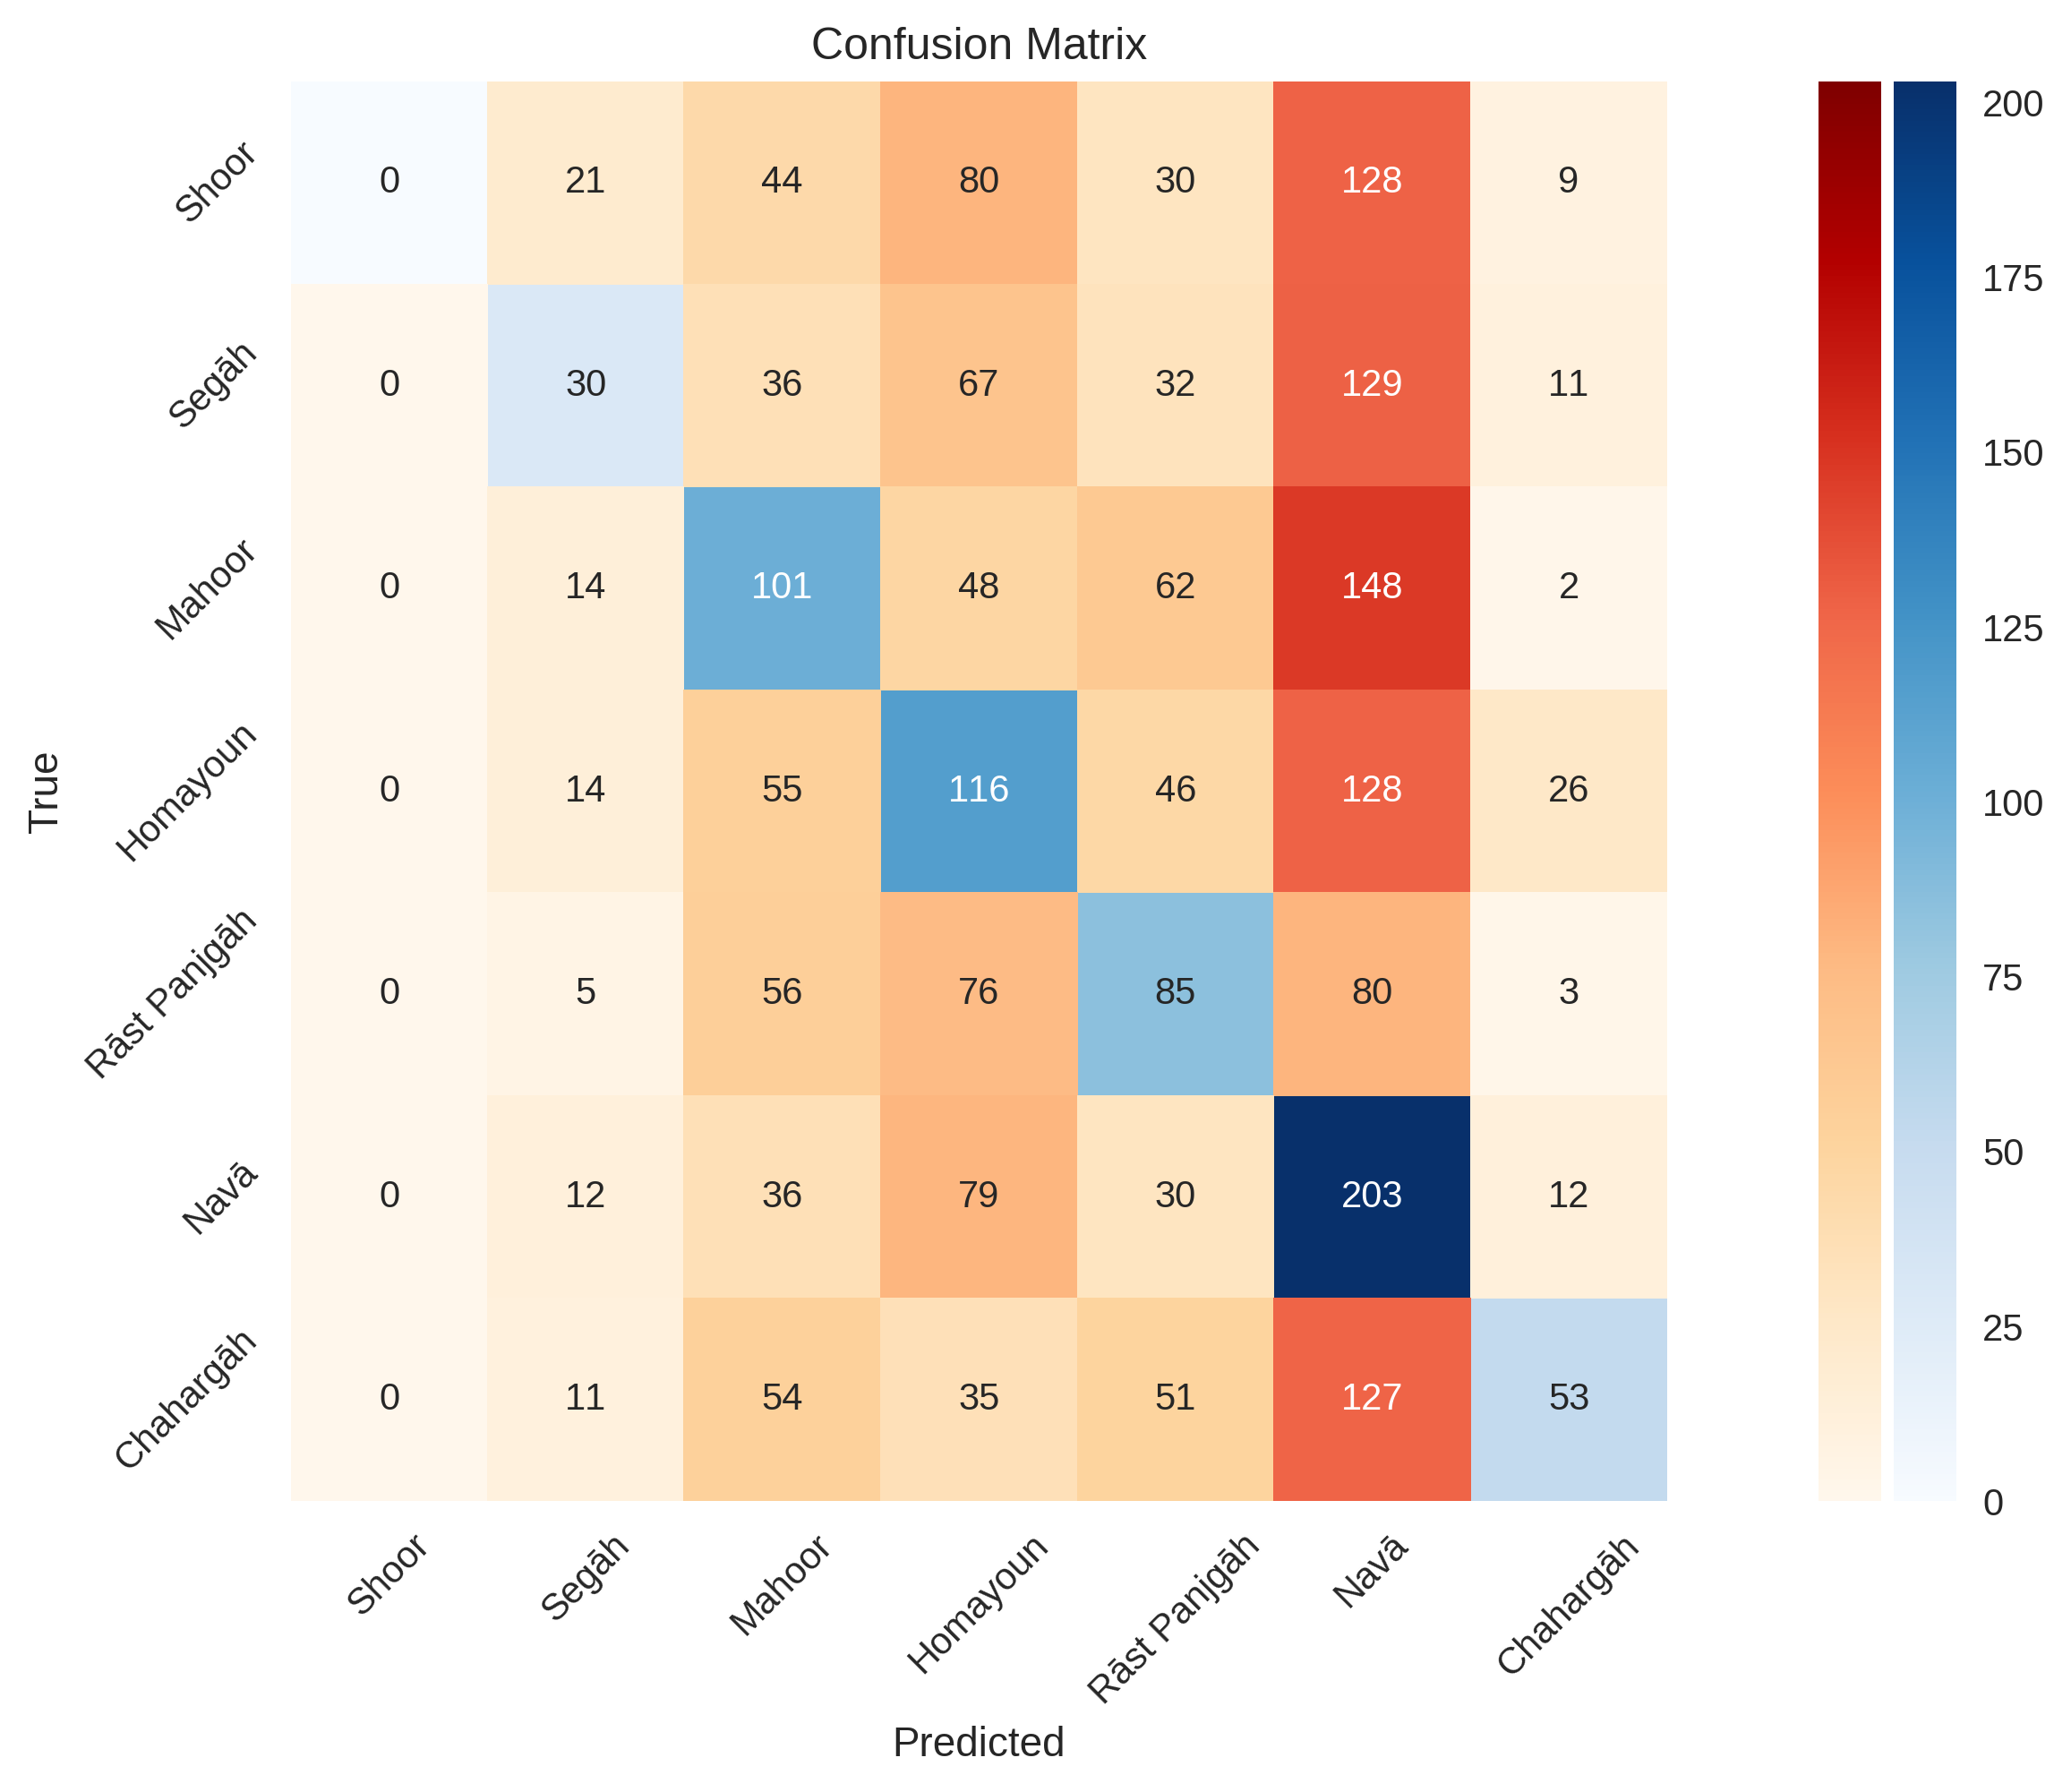

In [79]:
from sklearn.metrics import confusion_matrix

agg = get_agglomerative(X_train, 20, linkage='complete')
agg.fit_predict(X_train)
predict = agg.fit_predict(X_test)
y_pred = label_clusters(y_test, predict)
cm = confusion_matrix(y_test, y_pred)

vmin = np.min(cm)
vmax = np.max(cm)
off_diag_mask = np.eye(*cm.shape, dtype=bool)

fig = plt.figure(figsize=(8, 7))
gs0 = mpl.gridspec.GridSpec(1,2, width_ratios=[20,2], hspace=0.05)
gs00 = mpl.gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[1], hspace=0)

ax = fig.add_subplot(gs0[0])
cax1 = fig.add_subplot(gs00[0])
cax2 = fig.add_subplot(gs00[1])

sns.heatmap(cm, annot=True, fmt='g',
            mask=~off_diag_mask, cmap='Blues', 
            vmin=vmin, vmax=vmax, 
            ax=ax, cbar_ax=cax2
            )
sns.heatmap(cm, annot=True, fmt='g',
            mask=off_diag_mask, cmap='OrRd', 
            vmin=vmin, vmax=vmax, 
            ax=ax, cbar_ax=cax1, cbar_kws=dict(ticks=[])
            )

ax.set_xticklabels(label_names, rotation=45)
ax.set_yticklabels(label_names, rotation=45)

ax.set_title('Confusion Matrix', y=1.2)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

In [19]:
from sklearn.metrics import classification_report
predict = agg.fit_predict(X_train)
y_pred = label_clusters(y_train, predict)
print('training, complete linkage')
print(classification_report(y_train, y_pred, target_names=label_names, zero_division=0))

print('\n-------------------------------------------------\n')
predict = agg.fit_predict(X_test)
y_pred = label_clusters(y_test, predict)
print('testing, complete linkage')
print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))

training, complete linkage
              precision    recall  f1-score   support

       Shoor       0.18      0.45      0.26       941
       Segāh       0.50      0.00      0.00       948
      Mahoor       0.27      0.19      0.22      1074
    Homayoun       0.26      0.25      0.25      1107
Rāst Panjgāh       0.22      0.13      0.16       911
        Navā       0.41      0.13      0.20      1135
   Chahargāh       0.23      0.49      0.32      1037

    accuracy                           0.23      7153
   macro avg       0.30      0.23      0.20      7153
weighted avg       0.30      0.23      0.21      7153


-------------------------------------------------

testing, complete linkage
              precision    recall  f1-score   support

       Shoor       0.19      0.27      0.22       313
       Segāh       0.17      0.38      0.24       316
      Mahoor       0.30      0.19      0.23       358
    Homayoun       0.31      0.14      0.19       369
Rāst Panjgāh       0.19    

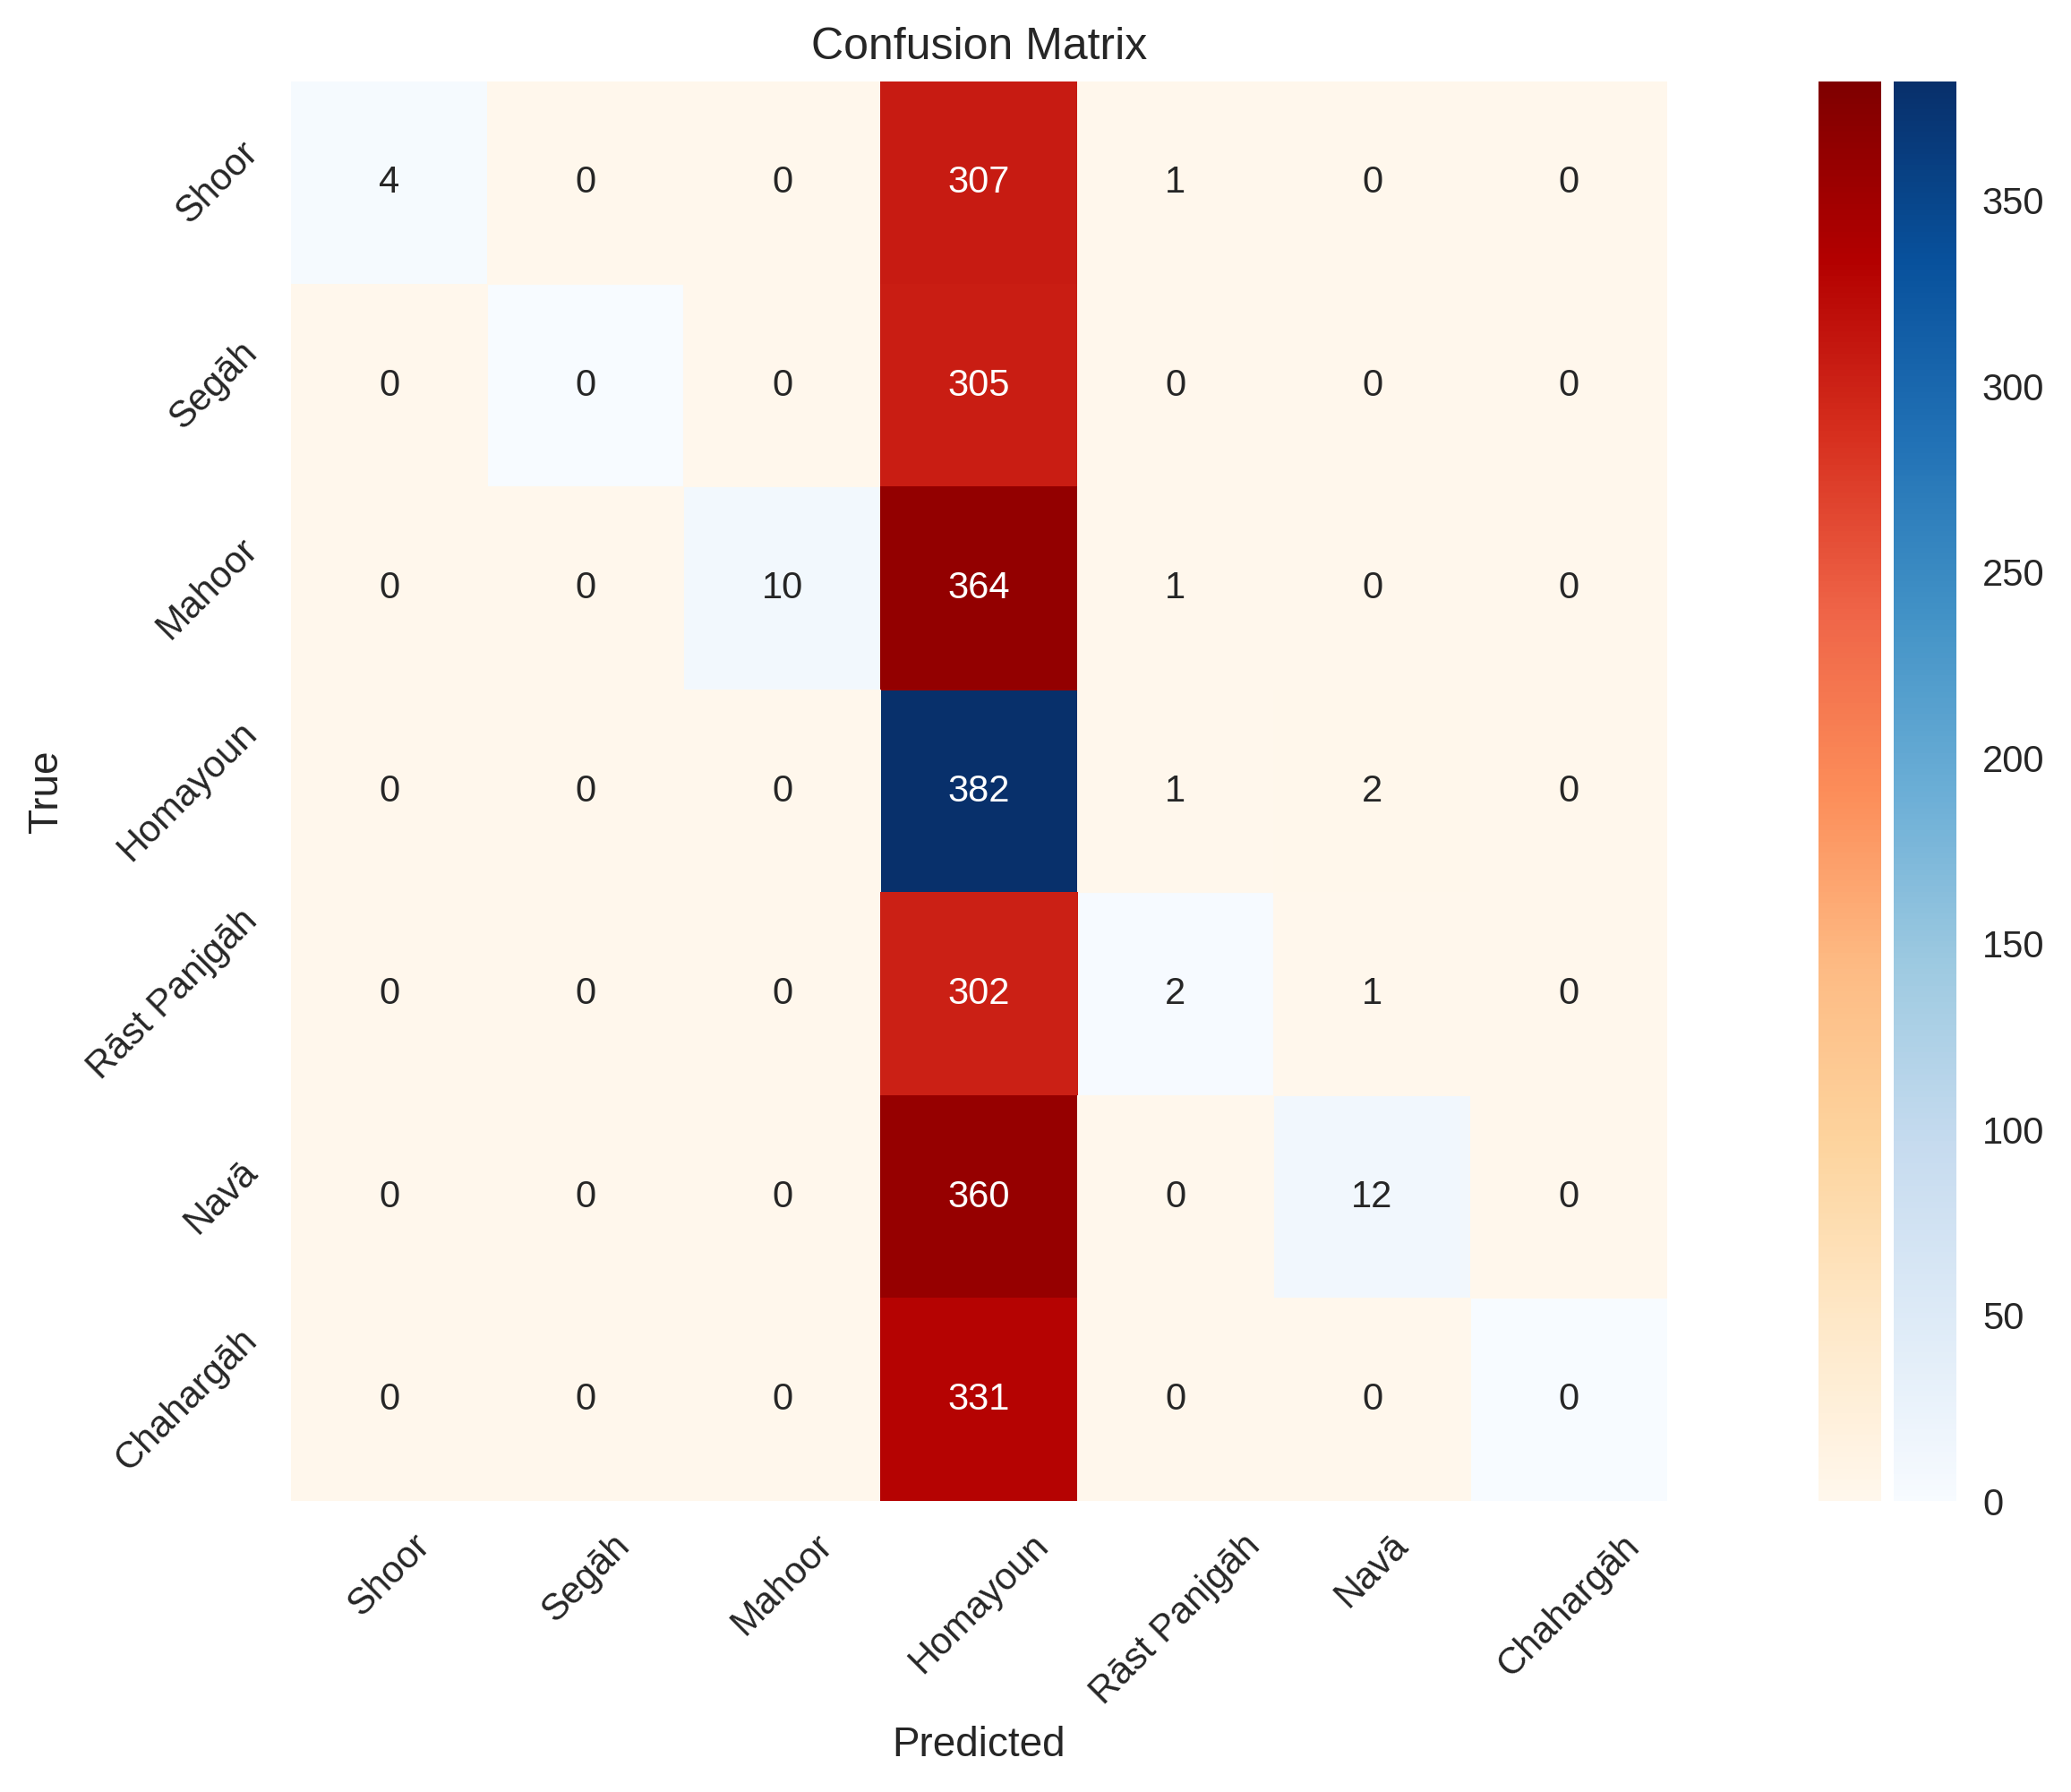

In [80]:
from sklearn.metrics import confusion_matrix

agg = get_agglomerative(X_train, 20, linkage='single')
agg.fit_predict(X_train)
predict = agg.fit_predict(X_test)
y_pred = label_clusters(y_test, predict)
cm = confusion_matrix(y_test, y_pred)

vmin = np.min(cm)
vmax = np.max(cm)
off_diag_mask = np.eye(*cm.shape, dtype=bool)

fig = plt.figure(figsize=(8, 7))
gs0 = mpl.gridspec.GridSpec(1,2, width_ratios=[20,2], hspace=0.05)
gs00 = mpl.gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[1], hspace=0)

ax = fig.add_subplot(gs0[0])
cax1 = fig.add_subplot(gs00[0])
cax2 = fig.add_subplot(gs00[1])

sns.heatmap(cm, annot=True, fmt='g',
            mask=~off_diag_mask, cmap='Blues', 
            vmin=vmin, vmax=vmax, 
            ax=ax, cbar_ax=cax2
            )
sns.heatmap(cm, annot=True, fmt='g',
            mask=off_diag_mask, cmap='OrRd', 
            vmin=vmin, vmax=vmax, 
            ax=ax, cbar_ax=cax1, cbar_kws=dict(ticks=[])
            )

ax.set_xticklabels(label_names, rotation=45)
ax.set_yticklabels(label_names, rotation=45)

ax.set_title('Confusion Matrix', y=1.2)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
predict = agg.fit_predict(X_train)
y_pred = label_clusters(y_train, predict)
print('training, single linkage')
print(classification_report(y_train, y_pred, target_names=label_names, zero_division=0))

print('\n-------------------------------------------------\n')
predict = agg.fit_predict(X_test)
y_pred = label_clusters(y_test, predict)
print('testing, single linkage')
print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))

training, single linkage
              precision    recall  f1-score   support

       Shoor       1.00      0.00      0.00       942
       Segāh       1.00      0.00      0.00       959
      Mahoor       1.00      0.00      0.01      1057
    Homayoun       1.00      0.01      0.01      1091
Rāst Panjgāh       1.00      0.00      0.01       910
        Navā       0.16      1.00      0.28      1142
   Chahargāh       1.00      0.00      0.01      1052

    accuracy                           0.16      7153
   macro avg       0.88      0.15      0.05      7153
weighted avg       0.87      0.16      0.05      7153


-------------------------------------------------

testing, single linkage
              precision    recall  f1-score   support

       Shoor       1.00      0.01      0.03       312
       Segāh       0.00      0.00      0.00       305
      Mahoor       1.00      0.03      0.05       375
    Homayoun       0.16      0.99      0.28       385
Rāst Panjgāh       0.40      0.

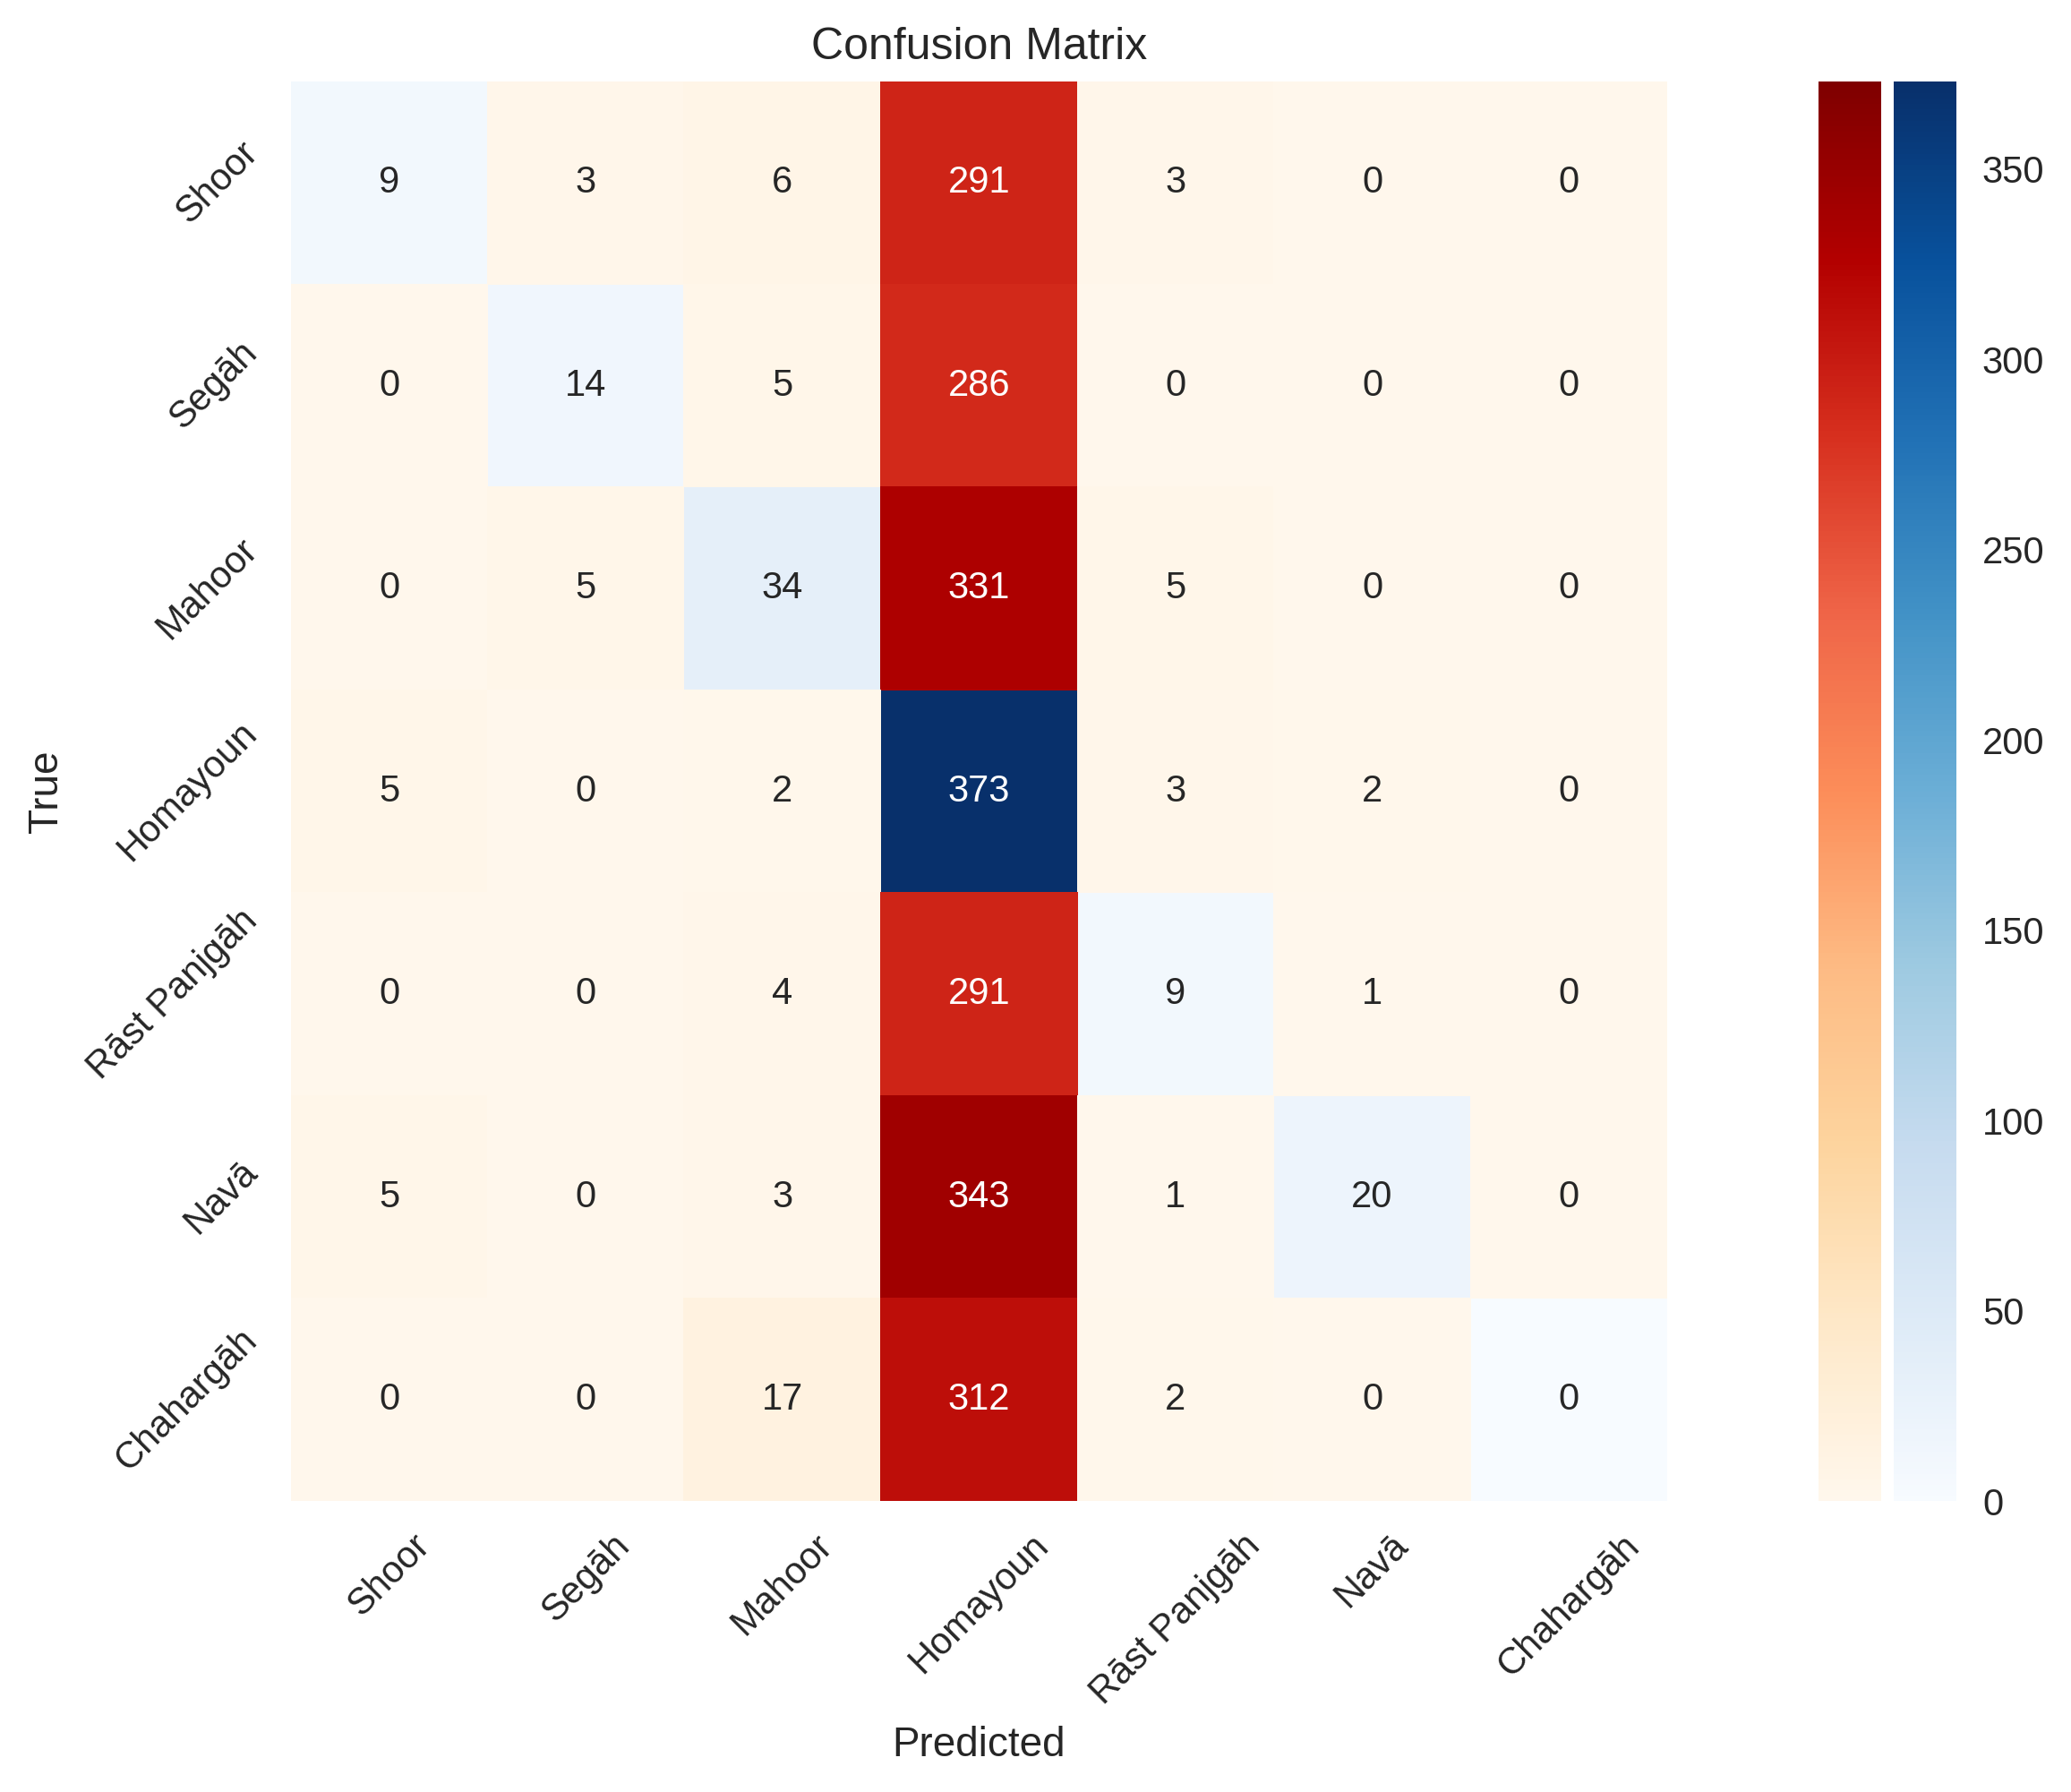

In [81]:
from sklearn.metrics import confusion_matrix

agg = get_agglomerative(X_train, 20, linkage='average')
agg.fit_predict(X_train)
predict = agg.fit_predict(X_test)
y_pred = label_clusters(y_test, predict)
cm = confusion_matrix(y_test, y_pred)

vmin = np.min(cm)
vmax = np.max(cm)
off_diag_mask = np.eye(*cm.shape, dtype=bool)

fig = plt.figure(figsize=(8, 7))
gs0 = mpl.gridspec.GridSpec(1,2, width_ratios=[20,2], hspace=0.05)
gs00 = mpl.gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[1], hspace=0)

ax = fig.add_subplot(gs0[0])
cax1 = fig.add_subplot(gs00[0])
cax2 = fig.add_subplot(gs00[1])

sns.heatmap(cm, annot=True, fmt='g',
            mask=~off_diag_mask, cmap='Blues', 
            vmin=vmin, vmax=vmax, 
            ax=ax, cbar_ax=cax2
            )
sns.heatmap(cm, annot=True, fmt='g',
            mask=off_diag_mask, cmap='OrRd', 
            vmin=vmin, vmax=vmax, 
            ax=ax, cbar_ax=cax1, cbar_kws=dict(ticks=[])
            )

ax.set_xticklabels(label_names, rotation=45)
ax.set_yticklabels(label_names, rotation=45)

ax.set_title('Confusion Matrix', y=1.2)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
predict = agg.fit_predict(X_train)
y_pred = label_clusters(y_train, predict)
print('training, average linkage')
print(classification_report(y_train, y_pred, target_names=label_names, zero_division=0))

print('\n-------------------------------------------------\n')
predict = agg.fit_predict(X_test)
y_pred = label_clusters(y_test, predict)
print('testing, average linkage')
print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))

training, average linkage
              precision    recall  f1-score   support

       Shoor       0.00      0.00      0.00       942
       Segāh       0.49      0.03      0.06       959
      Mahoor       0.53      0.04      0.08      1057
    Homayoun       0.61      0.01      0.02      1091
Rāst Panjgāh       0.29      0.15      0.20       910
        Navā       0.17      0.94      0.29      1142
   Chahargāh       0.26      0.03      0.05      1052

    accuracy                           0.19      7153
   macro avg       0.33      0.17      0.10      7153
weighted avg       0.34      0.19      0.10      7153


-------------------------------------------------

testing, average linkage
              precision    recall  f1-score   support

       Shoor       0.47      0.03      0.05       312
       Segāh       0.64      0.05      0.09       305
      Mahoor       0.48      0.09      0.15       375
    Homayoun       0.17      0.97      0.29       385
Rāst Panjgāh       0.39      

### Using PCA

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X36_all, y, test_size=0.25, random_state=42)

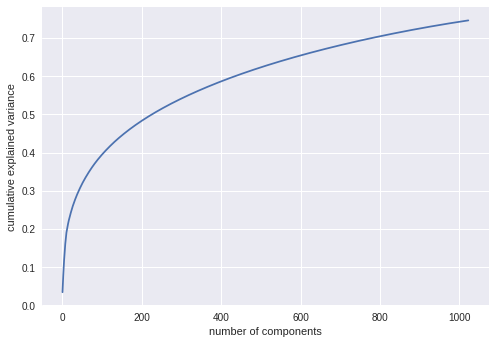

In [14]:
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

pca = PCA(n_components = 1024)
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [19]:
n_components = [2, 500, 1000]
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    kmeans = get_kmeans(X_train_pca, 20)
    predict = kmeans.predict(X_test_pca)
    y_pred = label_clusters(y_test, predict)
    print('testing, n_components =', n)
    print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))


testing, n_components = 2
              precision    recall  f1-score   support

       Shoor       0.18      0.22      0.20       312
       Segāh       0.22      0.12      0.15       305
      Mahoor       0.21      0.32      0.25       375
    Homayoun       0.25      0.28      0.26       385
Rāst Panjgāh       0.29      0.03      0.06       305
        Navā       0.22      0.38      0.27       372
   Chahargāh       0.23      0.10      0.14       331

    accuracy                           0.22      2385
   macro avg       0.23      0.21      0.19      2385
weighted avg       0.23      0.22      0.20      2385

testing, n_components = 500
              precision    recall  f1-score   support

       Shoor       0.22      0.26      0.24       312
       Segāh       0.21      0.08      0.12       305
      Mahoor       0.24      0.39      0.29       375
    Homayoun       0.25      0.44      0.32       385
Rāst Panjgāh       0.00      0.00      0.00       305
        Navā       0.38 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

pca = PCA()
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [22]:
n_components = [2, 500, 1000]
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    kmeans = get_kmeans(X_train_pca, 20)
    predict = kmeans.predict(X_test_pca)
    y_pred = label_clusters(y_test, predict)
    print('testing, n_components =', n)
    print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))


testing, n_components = 2
              precision    recall  f1-score   support

       Shoor       0.19      0.31      0.24       312
       Segāh       0.20      0.22      0.21       305
      Mahoor       0.21      0.16      0.18       375
    Homayoun       0.25      0.28      0.27       385
Rāst Panjgāh       0.27      0.03      0.05       305
        Navā       0.22      0.31      0.26       372
   Chahargāh       0.20      0.15      0.18       331

    accuracy                           0.21      2385
   macro avg       0.22      0.21      0.20      2385
weighted avg       0.22      0.21      0.20      2385

testing, n_components = 8
              precision    recall  f1-score   support

       Shoor       0.24      0.21      0.22       312
       Segāh       0.20      0.19      0.20       305
      Mahoor       0.26      0.38      0.31       375
    Homayoun       0.24      0.21      0.22       385
Rāst Panjgāh       0.24      0.19      0.21       305
        Navā       0.41   